<a href="https://colab.research.google.com/github/vtecftwy/metagenomics/blob/refactor_cnn_virus/nbs/2_01_EC_test_cnn_virus_code_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First experiments with CNN_Virus code

- Original code is in the github repo [here](https://github.com/MaHaoran627/CNN_Virus).
- This notebook includes basic refactoring of the CNN_Virus code for `tf.keras`.
- Refactored modules are on the repo [here](https://github.com/vtecftwy/metagenomics) under branch `refactor_cnn_virus`
- Status of the custom code:
    - `refactor_cnn_virus` branch is cloned locally and accessed later
    - `preprocessing.py`: 
        - `get_kmer_from_50mer(filepath, max_seqs=None)` allows to limit to a max number of sequences for initial experiments
        - small corrections in how keras functions are imported
    - `architecture.py`:
        - correction on hopw keras layers are imported and called

> This notebook assumes you have access to the `Metagenomics` gdrive shared folder, right under the grdive root. You should add a shortcut to the shared directory at the top of you gdrive.

In [1]:
import numpy as np
import os
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
COLAB = True

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
if COLAB:
    if not Path('repo').is_dir():
        !git clone -b refactor_cnn_virus https://github.com/vtecftwy/metagenomics.git repo

    cnn_src = Path('/content/repo/src')
    assert cnn_src.is_dir()

    data = Path('/content/gdrive/MyDrive/Metagenonics/CNN_Virus_data')
    assert data.is_dir()

    # add src where the custom code is into the path
    if cnn_src.is_dir():
        sys.path.insert(1, str(cnn_src))
        print(f"Added following path: {cnn_src}")
    else:
        print(f"There is no directory {cnn_src}")
else: 
    print('This notebook should run on colab')

# Preprocessing data

In [5]:
from preprocessing import get_learning_weights, get_params_50mer, get_kmer_from_50mer
from preprocessing import DataGenerator_from_50mer

from architecture import build_model

In [25]:
#path for the training file
filepath_train= data /"50mer_training"
assert filepath_train.is_file()
#path for the validating file
filepath_val= data / "50mer_validating"
assert filepath_val.is_file()
#path for the learning weights file
filepath_weights=data / "weight_of_classes"
assert filepath_weights.is_file()

Use function to get lists of sequences, labels and positions from text file

In [27]:
f_matrix, f_labels, f_pos = get_kmer_from_50mer(filepath_train, max_seqs=100_000)
len(f_matrix), len(f_labels), len(f_pos)

(100000, 100000, 100000)

In [28]:
i = 0
f_matrix[i], f_labels[i], f_pos[i]

('TCAAAATAATCAGAAATGTTGAACCTAGGGTTGGACACATAATGACCAGC', '76', '0')

Create the generators for training and validation using custom functions

In [33]:
d_nucl={"A":0,"C":1,"G":2,"T":3,"N":4}
f_matrix,f_labels,f_pos=get_kmer_from_50mer(filepath_train, max_seqs=100_000)
f_matrix_val,f_labels_val,f_pos_val=get_kmer_from_50mer(filepath_val, max_seqs=20_000)

params = get_params_50mer()
d_weights=get_learning_weights(filepath_weights)

training_generator = DataGenerator_from_50mer(f_matrix, f_labels, f_pos, **params)
val_generator = DataGenerator_from_50mer(f_matrix_val, f_labels_val, f_pos_val, **params)

In [34]:
len(training_generator)

98

Review the elements of generators

In [35]:
tg = training_generator.__getitem__(5)

In [36]:
len(tg), type(tg), type(tg[0]), type(tg[1])

(2, tuple, numpy.ndarray, dict)

In [45]:
inp, out_d = tg
print(type(inp), type(out_d))
print(out_d.keys())

<class 'numpy.ndarray'> <class 'dict'>
dict_keys(['output1', 'output2'])


In [46]:
inp.shape, out_d['output1'].shape, out_d['output2'].shape

((1024, 50, 5), (1024, 187), (1024, 10))

In [47]:
inp[:2, :4, :]

array([[[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]],

       [[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]]])

In [48]:
out1 = out_d['output1']
out2 = out_d['output2']

out1[:2, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Build model and review it

In [49]:
model=build_model()
model.summary()

Creating Model
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 50, 512)      13312       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 50, 512)     2048        ['conv1d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 25, 512)     0           ['batch_norm

In [50]:
model.compile(
	  optimizer='adam',
	  loss={'output1':'categorical_crossentropy','output2':'categorical_crossentropy'},
	  metrics=['accuracy'])

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

result = model.fit(
    training_generator,
	epochs=5,
	verbose=1,
	validation_data=val_generator,
	callbacks=[es]
	)


Epoch 1/5
98/98 [==============================] - 20s 202ms/step - loss: 5.9038 - output1_loss: 3.5918 - output2_loss: 2.3120 - output1_accuracy: 0.1782 - output2_accuracy: 0.1311 - val_loss: 6.1100 - val_output1_loss: 3.7917 - val_output2_loss: 2.3183 - val_output1_accuracy: 0.1409 - val_output2_accuracy: 0.1259
Epoch 2/5
98/98 [==============================] - 20s 201ms/step - loss: 5.6560 - output1_loss: 3.3567 - output2_loss: 2.2994 - output1_accuracy: 0.2195 - output2_accuracy: 0.1437 - val_loss: 6.1204 - val_output1_loss: 3.8203 - val_output2_loss: 2.3001 - val_output1_accuracy: 0.1444 - val_output2_accuracy: 0.1253
Epoch 3/5
98/98 [==============================] - 20s 200ms/step - loss: 5.4119 - output1_loss: 3.1173 - output2_loss: 2.2946 - output1_accuracy: 0.2845 - output2_accuracy: 0.1547 - val_loss: 6.2755 - val_output1_loss: 3.9558 - val_output2_loss: 2.3197 - val_output1_accuracy: 0.1339 - val_output2_accuracy: 0.1233
Epoch 4/5
98/98 [==============================] - 2

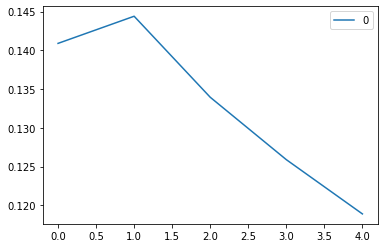

In [53]:
import pandas as pd
pd.DataFrame(result.history['val_output1_accuracy']).plot()

In [54]:
model.save(Path('saved_temp'))

In [55]:
from tensorflow.keras.models import load_model

m = load_model(Path('saved_temp'))

In [56]:
m.evaluate(val_generator)

20/20 [==============================] - 2s 62ms/step - loss: 7.9567 - output1_loss: 5.5393 - output2_loss: 2.4174 - output1_accuracy: 0.1189 - output2_accuracy: 0.1263


[7.956679821014404,
 5.539268970489502,
 2.417412281036377,
 0.11890000104904175,
 0.12630000710487366]